In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# =============================================================================
# Standard libraries
# =============================================================================
import os
import sys
import re
import gzip
import shutil
import pickle
from statistics import mode

# =============================================================================
# Third-party libraries
# =============================================================================
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import mmread
from scipy.sparse import csr_matrix
from sklearn import preprocessing, metrics
from sklearn.metrics.pairwise import euclidean_distances
from numpy.random import RandomState
import scanpy as sc
import torch
import torch_geometric
from torch_geometric.data import InMemoryDataset, Data, DataLoader
from torch_geometric.utils import *
from transformers import AutoModelForMaskedLM, AutoTokenizer
from tqdm import tqdm
import warnings
# Insert project_dir into sys.path so local modules can be imported
sys.path.insert(0, '/ibex/user/alsulara/PrePR-CT/')
import utils
import model
from utils import *
from model import *
import torch

if torch.cuda.is_available():
    print("CUDA is available. GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")

# =============================================================================
# Warning configuration
# =============================================================================
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# =============================================================================
# Configuration loader
# =============================================================================
def load_config(config_file):
    """Load configuration parameters from a YAML file."""
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
    return config

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


CUDA is available. GPU: Tesla V100-SXM2-32GB


In [2]:
# Specify the configuration file path
config_file = '/ibex/user/alsulara/PrePR-CT/training/config_train.yaml'

# Load configuration parameters from the YAML file
config = load_config(config_file)

# Extract configuration values (with defaults)
project_dir       = config.get('project_dir', '/ibex/user/alsulara/PrePR-CT/')
data_path         = config.get('data_path', 'Data/')
dataset           = config.get('dataset_h5ad', 'Neurips_Data_Processed.h5ad')
save_path_results = config.get('save_path_results', 'Results/')
save_path_models  = config.get('save_path_models', 'model_checkpoints/')
graphs_path       = config.get('graphs_path', 'graphs/')
graphs_data       = config.get('graphs_data', 'NeurIPS')
SMILES_feat       = config.get('SMILES_feat', 'SMILES_feat.csv')
multi_pert        = config.get('multi_pert', True)

# New parameters: testing cell type and testing drugs
testing_cell_type = config.get('testing_cell_type', ['B cells'])
testing_drugs     = config.get('testing_drugs', ["RG7090", "HYDROXYUREA"])

# Build full paths
full_data_path         = os.path.join(project_dir, data_path)
full_dataset_path      = os.path.join(full_data_path, dataset)
full_save_path_results = os.path.join(project_dir, save_path_results)
full_save_path_models  = os.path.join(project_dir, save_path_models)
full_graphs_path       = os.path.join(project_dir, graphs_path, graphs_data)
SMILES_feat_path       = os.path.join(full_data_path, SMILES_feat)

if len(testing_cell_type) > 1:
  full_save_path_results = full_save_path_results + '_unseen_pert_'


# Extract training parameters from the YAML file
params = config.get('params', {
    'hidden_channels': 128,
    'weight_decay': 1e-05,
    'in_head': 1,
    'learning_rate': -3,
    'num_epochs': 30,
    'batch_size': 512
})

# Print configuration for verification
print("Project Directory:", project_dir)
print("Data Path:", full_data_path)
print("Dataset Path:", full_dataset_path)
print("Graphs Path:", full_graphs_path)
print("Results Save Path:", full_save_path_results)
print("Models Save Path:", full_save_path_models)
print("Training Parameters:", params)
print("Testing Cell Type:", testing_cell_type)
print("Testing Drugs:", testing_drugs)

# =============================================================================
# Import Data
# =============================================================================
adata = sc.read(full_dataset_path)
del adata.raw


# -----------------------------------------------------------------------------
# Check and add required columns in adata.obs if not present
# -----------------------------------------------------------------------------



adata.obs['cov_drug'] = (adata.obs['cell_type'].astype(str) + '_' + adata.obs['condition'].astype(str))
# -----------------------------------------------------------------------------
# Load the coexpression network for each unique cell type
# -----------------------------------------------------------------------------
cell_type_network = {}
for cell_type in adata.obs.cell_type.unique():
    print(f"Loading network for: {cell_type}")
    graph_path = os.path.join(full_graphs_path, f"{cell_type}_coexpr_graph.pkl")
    cell_type_network[cell_type] = torch.load(graph_path)

# -----------------------------------------------------------------------------
# Matching Control & Treatment
# -----------------------------------------------------------------------------

ctrl_data = adata[adata.obs.condition == 'control']

# For each unique cell type, compute the mean and variance from control data
# and store them in the corresponding network object.
for cell_type in adata.obs.cell_type.unique():
    genes = cell_type_network[cell_type].pos.tolist()
    ctrl_subset = ctrl_data[ctrl_data.obs.cell_type == cell_type, genes].copy()
    
    # Compute mean and variance along the cell dimension (axis 0)
    mean_expr = torch.mean(torch.tensor(ctrl_subset.X.A), dim=0)
    var_expr  = torch.var(torch.tensor(ctrl_subset.X.A), dim=0)
    
    # Concatenate mean and variance (as separate columns) and assign to the network
    cell_type_network[cell_type].x = torch.cat(
        [mean_expr.unsqueeze(1), var_expr.unsqueeze(1)],
        dim=1
    )

Project Directory: /ibex/scratch/alsulara/PrePR-CT/
Data Path: /ibex/scratch/alsulara/PrePR-CT/Data/
Dataset Path: /ibex/scratch/alsulara/PrePR-CT/Data/Kang.h5ad
Graphs Path: /ibex/scratch/alsulara/PrePR-CT/graphs/Kang
Results Save Path: /ibex/scratch/alsulara/PrePR-CT/Results/
Models Save Path: /ibex/scratch/alsulara/PrePR-CT/model_checkpoints/
Training Parameters: {'hidden_channels': 64, 'weight_decay': 1e-05, 'in_head': 1, 'learning_rate': -3, 'num_epochs': 100, 'batch_size': 256}
Testing Cell Type: ['CD4 T cells']
Testing Drugs: ['stimulated']
Loading network for: CD14+ Monocytes
Loading network for: CD4 T cells
Loading network for: Dendritic cells
Loading network for: NK cells
Loading network for: CD8 T cells
Loading network for: B cells
Loading network for: FCGR3A+ Monocytes


Cells (train, OOD): 6774 5087
Training Starts


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 0, train loss: 12.059458909211335


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 1, train loss: 8.541488470854583


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 2, train loss: 7.980696307288276


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 3, train loss: 7.688471211327447


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 4, train loss: 7.520525579099302


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 5, train loss: 7.433205604553223


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 6, train loss: 7.335074265797933


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 7, train loss: 7.220571411980523


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 8, train loss: 7.114449977874756


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 9, train loss: 6.9964247279697


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 10, train loss: 6.854486306508382


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 11, train loss: 6.73635466893514


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 12, train loss: 6.593682642336245


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 13, train loss: 6.467235936058892


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 14, train loss: 6.327559259202745


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 15, train loss: 6.176695011280201


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 16, train loss: 6.027032181068703


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 17, train loss: 5.9001016970034


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 18, train loss: 5.745955502545392


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 19, train loss: 5.5964912485193326


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 20, train loss: 5.460192803983335


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 21, train loss: 5.3232911781028465


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 22, train loss: 5.1955924917150424


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 23, train loss: 5.080069294682255


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 24, train loss: 5.001373979780409


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 25, train loss: 4.870608223809136


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 26, train loss: 4.7629166532445835


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 27, train loss: 4.674636346322519


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 28, train loss: 4.585142153280753


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 29, train loss: 4.485830395310013


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 30, train loss: 4.401272367548059


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 31, train loss: 4.320486704508464


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 32, train loss: 4.251483722969338


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 33, train loss: 4.186709686561867


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 34, train loss: 4.114515746081317


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 35, train loss: 4.061912077444571


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 36, train loss: 4.006570003650807


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 37, train loss: 3.9456362812607377


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 38, train loss: 3.9052762190500894


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 39, train loss: 3.8525596106493913


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 40, train loss: 3.811674471254702


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 41, train loss: 3.761330737007989


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 42, train loss: 3.7314429812961154


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 43, train loss: 3.672310334664804


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 44, train loss: 3.6434731483459473


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 45, train loss: 3.6102980507744684


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 46, train loss: 3.568764536469071


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 47, train loss: 3.5369431089471886


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 48, train loss: 3.5056113755261458


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 49, train loss: 3.49075064835725


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 50, train loss: 3.469926604518184


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 51, train loss: 3.430040023944996


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 52, train loss: 3.4015916100254766


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 53, train loss: 3.372593323389689


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 54, train loss: 3.357173654768202


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 55, train loss: 3.3395278542130082


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 56, train loss: 3.312929073969523


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 57, train loss: 3.2834898365868463


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 58, train loss: 3.2658145780916565


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 59, train loss: 3.251125441657172


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 60, train loss: 3.2364977377432362


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 61, train loss: 3.2192023153658265


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 62, train loss: 3.2022309479890048


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 63, train loss: 3.1783722506629095


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 64, train loss: 3.1754034890068903


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 65, train loss: 3.160224861568875


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 66, train loss: 3.1439175694077104


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 67, train loss: 3.129463169309828


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 68, train loss: 3.1292551358540854


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 69, train loss: 3.1209656132592096


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 70, train loss: 3.0927857204719826


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 71, train loss: 3.073550056528162


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 72, train loss: 3.0756996031160706


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 73, train loss: 3.063856363296509


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 74, train loss: 3.041953236968429


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 75, train loss: 3.044352345996433


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 76, train loss: 3.0304929150475397


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 77, train loss: 3.017666728408248


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 78, train loss: 3.0024150565818504


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 79, train loss: 2.995490383218836


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 80, train loss: 2.983919964896308


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 81, train loss: 2.9764245880974665


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 82, train loss: 2.963523502703066


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 83, train loss: 2.9764424871515343


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 84, train loss: 2.95970379864728


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 85, train loss: 2.9435585428167275


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 86, train loss: 2.9381413194868298


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 87, train loss: 2.9322523452617504


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 88, train loss: 2.9241854084862604


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 89, train loss: 2.9206390027646667


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 90, train loss: 2.9202024936676025


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 91, train loss: 2.9114390125981084


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 92, train loss: 2.899780202794958


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 93, train loss: 2.8956703344980874


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 94, train loss: 2.889825794431898


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 95, train loss: 2.8863070982473866


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 96, train loss: 2.8826282995718495


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 97, train loss: 2.8845630751715765


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 98, train loss: 2.866964755234895


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 99, train loss: 2.867158536557798


  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------- Mean Expression Predicton -----------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

CD4 T cells_stimulated  mse:  0.0072574993
R² value for predicting the **mean** expression of all genes for perturbation 'CD4 T cells_stimulated': 0.9787
R² value for predicting the **mean** of the top 100 DEGs for perturbation 'CD4 T cells_stimulated': 0.9929
-------------------------------------------- Std Expression Predicton -----------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

CD4 T cells_stimulated  mse:  0.0072575095
R² value for predicting the **standard deviation** expression of all genes for perturbation 'CD4 T cells_stimulated': 0.8260
R² value for predicting the **standard deviation** of the top 100 DEGs for perturbation 'CD4 T cells_stimulated': 0.9165


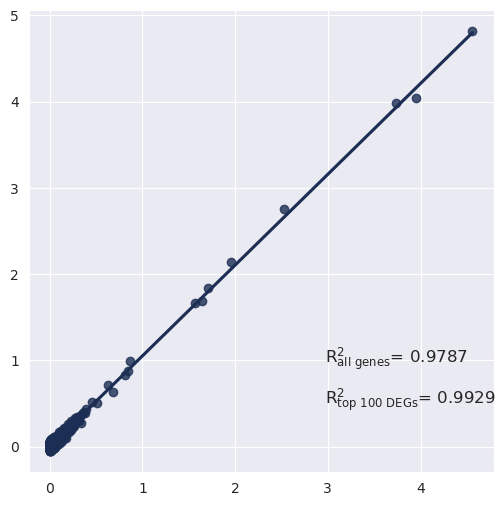

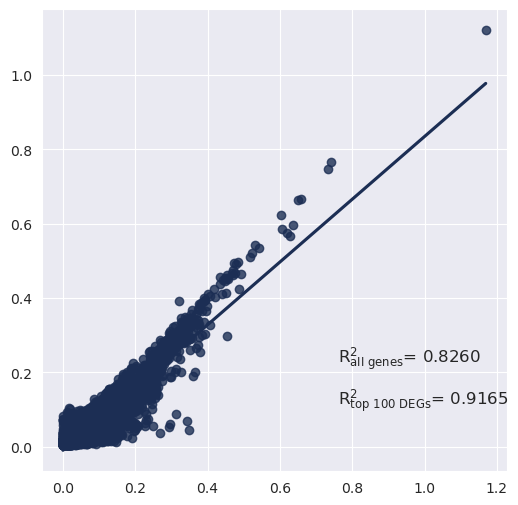

In [3]:
# -----------------------------------------------------------------------------
# Prepare Data for Training
# -----------------------------------------------------------------------------

# Create cell data using the provided function
    
with open(full_data_path + 'cells_'+graphs_data+'.pkl', 'rb') as pickle_file:
    cell_all_Data = pickle.load(pickle_file)
    
# Extract unique cov_drug values for testing drugs and the specified testing cell type
testing_cov_drug = list(adata[
    ((adata.obs['condition'].isin(testing_drugs)) & 
    (adata.obs['cell_type'].isin(testing_cell_type)))
].copy().obs['cov_drug'].unique())

# Partition the samples into training and out-of-distribution (OOD) sets
cells_ood = [sample for sample in cell_all_Data if sample.cov_drug in testing_cov_drug]
cells_train = [sample for sample in cell_all_Data if sample.cov_drug not in testing_cov_drug]

# Print the number of cells in each group
print("Cells (train, OOD):", len(cells_train), len(cells_ood))

# -----------------------------------------------------------------------------
# Training & Testing
# -----------------------------------------------------------------------------
train_dataloader = DataLoader(cells_train, batch_size = params['batch_size'], shuffle=True)
torch.manual_seed(42) 
model = GNN(total_genes  = len(adata.var), num_perts = 110, act_fct = 'Sigmoid',
            hidden_channels = params['hidden_channels'], in_head = params['in_head'],  multi_pert = multi_pert).to(device)
model = train(model = model, num_epochs = params['num_epochs'], lr = 10**params['learning_rate'],
              weight_decay = params['weight_decay'], multi_pert = multi_pert, 
              cell_type_network = cell_type_network, train_loader = train_dataloader)

torch.save(model.state_dict(), full_save_path_models+'_'+graphs_data+"_model.pt")
model.load_state_dict(torch.load(full_save_path_models+'_'+graphs_data+"_model.pt"))
degs_dict = {}

degs_dict = {}
for cov_drug in tq.tqdm(set(adata[adata.obs.cov_drug.isin(testing_cov_drug)].obs.cov_drug.unique())):
    testing_drug = cov_drug.split('_')[1]
    ood_cell = cov_drug.split('_')[0]
    genes = cell_type_network[ood_cell].pos.tolist()
    adata_cov = adata[
        adata.obs.cov_drug.isin([cov_drug, ood_cell + '_control']), genes
    ].copy()
    sc.tl.rank_genes_groups(
        adata_cov,
        groupby='cov_drug',
        rankby_abs=True,
        method='t-test',
        corr_method='benjamini-hochberg',
        reference=ood_cell + '_control',
        n_genes=len(adata_cov.var)
    )
    dedf = sc.get.rank_genes_groups_df(adata_cov, group=cov_drug)
    dedf = dedf.loc[dedf['pvals_adj'] < 0.05].copy()
    DEGs_name = rank_genes(dedf)
    mask = adata_cov.var_names.isin(DEGs_name)
    indices_np = np.where(mask)[0]
    degs_dict[cov_drug] = indices_np

    
ood_loader_all = DataLoader(cells_ood, batch_size=params['batch_size'], shuffle=True)
print("-------------------------------------------- Mean Expression Predicton -----------------------------------------------------------")
Inference_multi_pert(cell_type_network, model, full_save_path_results, 
                    ood_loader_all, adata, degs_dict = degs_dict, mean_or_std = True, plot = True, multi_pert = multi_pert) 
                    
print("-------------------------------------------- Std Expression Predicton -----------------------------------------------------------")
Inference_multi_pert(cell_type_network, model, full_save_path_results, 
                    ood_loader_all, adata, degs_dict = degs_dict, mean_or_std = False, plot = True, multi_pert = multi_pert)